# Evolutionary Algorithm

the Evolutionary Algorithm that is supposed to create new recipes based on the Recipe Matrices that are created during the *Recipe Analysis* step.

The Population of the Evolutional Algorithm consists of a set of recipe trees. Each Recipe Tree consists of several Nodes where each node is of one of the following Types:

* **Ingredient Node:**
  these are the leaf nodes. Containing an ingredient. The score is determined by the actions, that are applied if you follow up the path. At the Moment it measures how many duplicate actions are applied.
* **Action Node:**
  An Action that is applied on it's child and this child's subtree. Score indicates the average likelihood that this action is applied on the ingredients inside the subtree
* **Mix Node:**
  Mixing ingredients together. This is also the only Node that can have more than one child. The score is the average of all pairwise likelihoods that two ingredients are mixed togethter

In [1]:
import sys
sys.path.append("../")
sys.path.append("../RecipeAnalysis/")

In [2]:
import settings

import pycrfsuite

import json

import db.db_settings as db_settings
from db.database_connection import DatabaseConnection

from Tagging.conllu_generator import ConlluGenerator
from Tagging.crf_data_generator import *

from RecipeAnalysis.Recipe import Ingredient

import ea_tools

from difflib import SequenceMatcher

import numpy as np

import ActionGroups as AG

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

from graphviz import Digraph

import itertools

import random

import plotly.io as pio
pio.renderers.default = "jupyterlab"

from IPython.display import Markdown, HTML, display

from tqdm.autonotebook import tqdm

from copy import deepcopy

/home/jonas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [3]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

## load adjacency matrices

In [4]:
import dill
m_act = dill.load(open("../RecipeAnalysis/m_act.dill", "rb"))
m_mix = dill.load(open("../RecipeAnalysis/m_mix.dill", "rb"))
m_base_act = dill.load(open("../RecipeAnalysis/m_base_act.dill", "rb"))
m_base_mix = dill.load(open("../RecipeAnalysis/m_base_mix.dill", "rb"))


m_grouped_mix = dill.load(open("../RecipeAnalysis/m_grouped_mix_raw.dill", "rb"))
m_grouped_act = dill.load(open("../RecipeAnalysis/m_grouped_act_raw.dill", "rb"))
m_grouped_base_act = dill.load(open("../RecipeAnalysis/m_grouped_base_act_raw.dill", "rb"))


#m_act.apply_threshold(3)
#m_mix.apply_threshold(3)
#m_base_act.apply_threshold(5)
#m_base_mix.apply_threshold(5)


#c_act = m_act.get_csr()
#c_mix = m_mix.get_csr()
#c_base_act = m_base_act.get_csr()
#c_base_mix = m_base_mix.get_csr()

m_act.compile()
m_mix.compile()
m_base_act.compile()
m_base_mix.compile()

m_grouped_mix.compile()
m_grouped_act.compile()
m_grouped_base_act.compile()

c_act = m_act._csr
c_mix = m_mix._csr
c_base_act = m_base_act._csr
c_base_mix = m_base_mix._csr


In [5]:
actions = m_act.get_labels()[0]

In [6]:
base_ingredients = m_base_mix.get_labels()

In [7]:
sym_label_buffer = {}
fw_label_buffer = {}
bw_label_buffer = {}

### helper functions for adjacency matrices

In [8]:
def get_sym_adjacent(key, m, c):
    index = m._label_index[key]
    i1 = c[index,:].nonzero()[1]
    i2 = c[:,index].nonzero()[0]
    
    i = np.concatenate((i1,i2))
    
    if m in sym_label_buffer:
        names = sym_label_buffer[m][i]
    else:
        names = np.array(m.get_labels())
        sym_label_buffer[m] = names
        names = names[i]
    
    counts = np.concatenate((c[index, i1].toarray().flatten(), c[i2, index].toarray().flatten()))
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [9]:
def get_forward_adjacent(key, m, c):
    index = m._x_label_index[key]
    i = c[index,:].nonzero()[1]
    
    if m in fw_label_buffer:
        names = fw_label_buffer[m][i]
    else:
        names = np.array(m._y_labels)
        fw_label_buffer[m] = names
        names = names[i]
    
    
    counts = c[index, i].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [10]:
def get_backward_adjacent(key, m, c):
    index = m._y_label_index[key]
    i = c[:,index].nonzero()[0]
    
    if m in bw_label_buffer:
        names = bw_label_buffer[m][i]
    else:
        names = np.array(m._x_labels)
        bw_label_buffer[m] = names
        names = names[i]
    
    
    counts = c[i, index].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [11]:
def sym_sum(key, m, c):
    return np.sum(get_sym_adjacent(key,m,c)[1])

def fw_sum(key, m, c):
    return np.sum(get_forward_adjacent(key,m,c)[1])

def bw_sum(key, m, c):
    return np.sum(get_backward_adjacent(key,m,c)[1])

#### different score functions

##### normalizations

In [12]:
def fw_normalization_factor(key, m, c, quotient_func):
    ia = m._x_label_index[key]
    
    occurances = c[ia,:].nonzero()[1]
    
    return 1. / quotient_func(c[ia,occurances].toarray())

def bw_normalization_factor(key, m, c, quotient_func):
    ib = m._y_label_index[key]
    
    occurances = c[:,ib].nonzero()[0]
    
    return 1. / quotient_func(c[occurances,ib].toarray())

def sym_normalization_factor(key, m, c, quotient_func):
    ii = m._label_index[key]
    
    fw_occurances = c[ii,:].nonzero()[1]
    bw_occurances = c[:,ii].nonzero()[0]
    
    return 1. / quotient_func(np.concatenate(
        [c[ii,fw_occurances].toarray().flatten(),
         c[bw_occurances,ii].toarray().flatten()]
    ))

In [13]:
def sym_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._label_index[key_a]
    ib = m._label_index[key_b]
    
    v = c[ia,ib] + c[ib,ia]
    
    return v * sym_normalization_factor(key_b, m, c, quot_func)

def fw_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._x_label_index[key_a]
    ib = m._y_label_index[key_b]
    
    v = c[ia,ib]
    
    return v * bw_normalization_factor(key_b, m, c, quot_func)

def bw_p_a_given_b(key_a, key_b, m, c, quot_func = np.max):
    ia = m._y_label_index[key_a]
    ib = m._x_label_index[key_b]
    
    v = c[ib,ia]
    
    return v * fw_normalization_factor(key_b, m, c, quot_func)


In [14]:
def sym_score(key_a, key_b, m, c):

    ia = m._label_index[key_a]
    ib = m._label_index[key_b]
    
    v = c[ia,ib] + c[ib,ia]
    
    if v == 0:
        return 0
    
    return max((v/sym_sum(key_a, m, c)), (v/sym_sum(key_b, m, c)))

def asym_score(key_a, key_b, m, c):
    ia = m._x_label_index[key_a]
    ib = m._y_label_index[key_b]
    
    v = c[ia,ib]
    
    if v == 0:
        return 0
    
    return max(v/fw_sum(key_a, m, c), v/bw_sum(key_b, m, c))

In [15]:
def p_ingredient_unprepared(base_ing):
    ing = Ingredient(base_ing)
    base_sum = sym_sum(base_ing, m_base_mix, c_base_mix)
    specialized_sum = sym_sum(ing.to_json(), m_mix, c_mix)
    return specialized_sum / base_sum

**new probability for preprocess ingredients:**

In [16]:
def prepare_ratio(ing:str):
    keys, values = m_grouped_act.get_backward_adjacent(Ingredient(ing).to_json())
    action_dict = dict(zip(keys,values))
    return action_dict['prepare'] / action_dict['heat']

def random_prepare(ing:str):
    """
    returns randomly a boolean value if ing should be prepared, w.r.t. the prepare_ration function
    """
    
    return prepare_ratio(ing) > np.random.normal(0.35,0.1)

def random_heated(ingredient:str):
    action_set, action_weights = m_grouped_base_act.get_backward_adjacent(ingredient)
    d = dict(zip(action_set, action_weights))
    ratio = 1 - d['prepare'] / d['heat']
    
    return ratio > np.random.normal(0.65,0.15)


In [17]:
def relative_action_rank(ingredient:str, action:str):
    action_set, action_weights = m_base_act.get_backward_adjacent(ingredient)
    if action not in action_set or len(action_set) <= 1:
        return 0
    return 1 - action_set.tolist().index(action) / (len(action_set) - 1)

In [18]:
def filter_set_by_group(act_set, act_w, group):
    new_act_set = []
    new_act_w = []
    for i in range(len(act_set)):
        if act_set[i] in AG.inverse_groups[group]:
            new_act_set.append(act_set[i])
            new_act_w.append(act_w[i])
    return np.array(new_act_set), np.array(new_act_w)

## better normalized scores:

In [31]:
def normalized_score(key, matrix):
    sum_key = matrix.get_sum(key)
    keys, values = matrix.get_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

def forward_normalized_score(key, matrix):
    sum_key = matrix.get_fw_sum(key)
    keys, values = matrix.get_forward_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_bw_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

def backward_normalized_score(key, matrix):
    sum_key = matrix.get_bw_sum(key)
    keys, values = matrix.get_backward_adjacent(key)
    normalized_values = np.array([(values[i] / matrix.get_fw_sum(keys[i])) * (values[i] / sum_key) for i in range(len(keys))])
    sort = np.argsort(-normalized_values)
    return keys[sort], normalized_values[sort]

## Recipe Tree
### Tree Node Base Class

In [20]:
class RecipeTreeNode(object):
    
    id = 0
    
    def __init__(self, name, constant=False, single_child=False):
        self._constant = constant
        self._name = name
        self._parent = None
        
        self._id = str(RecipeTreeNode.id)
        RecipeTreeNode.id += 1
        
        self._single_child = single_child
        
        if self._single_child:
            self._child = None
            
            def child():
                return self._child
            
            def remove_child(c):
                assert c == self._child
                self._child._parent = None
                self._child = None
            
            def childs():
                c = self.child()
                if c is None:
                    return set()
                return set([c])
            
            def add_child(n):
                self._child = n
                n._parent = self
            
            self.child = child
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
        else:
            self._childs = set()
            
            def childs():
                return self._childs
            
            def add_child(n):
                self._childs.add(n)
                n._parent = self
            
            def remove_child(c):
                assert c in self._childs
                c._parent = None
                self._childs.remove(c)
            
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
    
    def parent(self):
        return self._parent
    
    def root(self):
        if self._parent is None:
            return self
        return self._parent.root()
    
    def name(self):
        return self._name
    
    def traverse(self):
        l = []
        
        for c in self.childs():
            l += c.traverse()
        
        return [self] + l
    
    def traverse_ingredients(self):
        ingredient_set = []
        for c in self.childs():
            ingredient_set += c.traverse_ingredients()
        
        return ingredient_set
    
    def remove(self):
        p = self.parent()
        childs = self.childs().copy()
        
        assert p is None or not (len(childs) > 1 and p._single_child)
        
        for c in childs:
            self.remove_child(c)
        
        if p is not None:
            p.remove_child(self)
            
            if self._single_child and self._child is not None and p._name == self._child._name:
                # two adjacent nodes with same name would remain after deletion.
                # merge them! (by adding the child's childs to our parent instead of our childs)
                childs = self._child.childs()
                self._child.remove()
                
            
            for c in childs:
                p.add_child(c)
    
    def insert_before(self, n):
        p = self._parent
        if p is not None:
            p.remove_child(self)
            p.add_child(n)
        n.add_child(self)
        
    def mutate(self):
        n_node = self.n_node_mutate_options()
        n_edge = self.n_edge_mutate_options()
        
        choice = random.choice(range(n_node + n_edge))
        if choice < n_node:
            self.mutate_node()
        else:
            self.mutate_edges()
    
    def mutate_edges(self):
        ings = self.traverse_ingredients()
        ing = random.choice(ings)
        
        a, w = get_backward_adjacent(ing._base_ingredient, m_base_act, c_base_act)
 
        action = random.choices(a, w)[0]
        self.insert_before(ActionNode(action))
    
    def mutate_node(self):
        raise NotImplementedError
    
    def n_node_mutate_options(self):
        
        return 0 if self._constant else 1
    
    def n_edge_mutate_options(self):
        n = 1 if self._parent is not None else 0
        return n
    
    def n_mutate_options(self):
        return self.n_edge_mutate_options() + self.n_node_mutate_options()
        
    def dot_node(self, dot):
        raise NotImplementedError()
    
    def dot(self, d=None):
        if d is None:
            d = Digraph()
            self.dot_node(d)
        
        else:
            self.dot_node(d)
            if self._parent is not None:
                d.edge(self._parent._id, self._id)
        
        
        for c in self.childs():
            c.dot(d)
        
        return d
    
    def serialize(self):
        r = {}
        r['type'] = str(self.__class__.__name__)
        r['id'] = self._id
        r['parent'] = self._parent._id if self._parent is not None else None
        r['name'] = self._name
        r['childs'] = [c._id for c in self.childs()]
        r['constant'] = self._constant
        r['single_child'] = self._single_child
        
        return r
    
    def node_score(self):
        raise NotImplementedError()
        


### Mix Node

For the Node Score: just make a simple lookup whether this combination is seen or not. So the node Score is defined as:


In [21]:
class MixNode(RecipeTreeNode):
    def __init__(self, constant=False):
        super().__init__("mix", constant, single_child=False)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score: {self.node_score():.4f}>", shape="diamond", style="filled", color="#d5e8d4")
    
    def split(self, set_above, set_below, node_between):
        assert len(set_above.difference(self.childs())) == 0
        assert len(set_below.difference(self.childs())) == 0
        
        n_above = MixNode()
        n_below = MixNode()
        
        p = self.parent()
        
        for c in self.childs().copy():
            self.remove_child(c)
        self.remove()
        
        for c in set_below:
            n_below.add_child(c)
        
        for c in set_above:
            n_above.add_child(c)
        
        n_above.add_child(node_between)
        node_between.add_child(n_below)
        
        if p is not None:
            p.add_child(n_above)
        
        # test whether the mix nodes are useless
        if len(n_above.childs()) == 1:
            n_above.remove()
        
        if len(n_below.childs()) == 1:
            n_below.remove()
    
    def n_node_mutate_options(self):
        return 0 if self._constant or len(self.childs()) <= 2 else len(self.childs())
    
    def mutate_node(self):
        
        childs = self.childs()
        
        if len(childs) <= 2:
            print("Warning: cannot modify mix node")
            return
        
        childs = random.sample(childs, len(childs))
        
        n = random.choice(range(1, len(childs)-1))
        
        between_node = ActionNode(random.choice(actions))
        
        self.split(set(childs[:n]), set(childs[n:]), between_node)
        
    
    def node_score(self):
        child_ingredients = [c.traverse_ingredients() for c in self.childs()]
        
        tmp_set = set()
        cumulative_sets = []
        
        pairwise_tuples = []
        
        for c in child_ingredients:
            if len(tmp_set) > 0:
                cumulative_sets.append(tmp_set)
                pairwise_tuples += [x for x in itertools.product(tmp_set, c)]
            tmp_set = tmp_set.union(set(c))
        
        s_base = 0
        s = 0
        
        for ing_a, ing_b in pairwise_tuples:
            try:
                #s_base += sym_score(ing_a._base_ingredient, ing_b._base_ingredient, m_base_mix, c_base_mix)
                
                #s += sym_score(ing_a.to_json(), ing_b.to_json(), m_mix, c_mix)
                
                # old method:
                #p1 = sym_p_a_given_b(ing_a.to_json(), ing_b.to_json(), m_mix, c_mix)
                #p2 = sym_p_a_given_b(ing_b.to_json(), ing_a.to_json(), m_mix, c_mix)
                #s += 0.5 * p1 + 0.5 * p2
                
                
                ia = m_mix._label_index[ing_a.to_json()]
                ib = m_mix._label_index[ing_b.to_json()]
                
                if c_mix[ia,ib] > 0 or c_mix[ib,ia] > 0:
                    s += 1
                
                
                
            except KeyError as e:
                pass
        
        #s_base /= len(pairwise_tuples)
        s /= len(pairwise_tuples)
        
        #return 0.5 * (s_base + s)
        return s
    
        
        


### Ingredient Node Class

In [22]:
class IngredientNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def get_actions(self):
        a_list = []
        n = self.parent()
        while n is not None:
            if type(n) == ActionNode:
                a_list.append(n.name())
            n = n.parent()
        return a_list
    
    def mutate_node(self):
        self._name = random.choice(base_ingredients)
        #TODO: change w.r.t. mixing probabilities 
    
    def traverse_ingredients(self):
        return [Ingredient(self._name)]
    
    def node_score(self):
        actions = self.get_actions()
        
        if len(actions) == 0:
            if p_ingredient_unprepared(self._name) < 0.2:
                return 0
            return 1
        
        seen_actions = set()
        n_duplicates = 0
        for act in actions:
            if act in seen_actions:
                n_duplicates += 1
            else:
                seen_actions.add(act)
        
        duplicate_actions_score = len(seen_actions) / len(actions)
        
        return duplicate_actions_score
        
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score:{self.node_score():.4f}>", shape="box", style="filled", color="#ffe6cc")

### Action Node Class

In [23]:
class ActionNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def n_node_mutate_options(self):
        # beacause we can change or remove ourselve!
        return 0 if self._constant else 2 
    def mutate_node(self):
        if random.choice(range(2)) == 0:
            # change action
            self._name = random.choice(actions)
        else:
            # delete
            self.remove()
    
    def traverse_ingredients(self):
        ingredient_set = super().traverse_ingredients()
        for ing in ingredient_set:
            ing.apply_action(self._name)
        
        return ingredient_set
    
    def node_score(self):
        ings = self.child().traverse_ingredients()
        
        s = 0
        
        for ing in ings:
            try:
                #score = asym_score(self._name, ing.to_json(), m_act, c_act)
                #base_score = asym_score(self._name, ing._base_ingredient, m_base_act, c_base_act)
                
                score = fw_p_a_given_b(self._name, ing._base_ingredient, m_base_act, c_base_act)
                
                s +=  score
            except KeyError as e:
                pass
                
        
        return s / len(ings)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"< <B>{self._name}</B><BR/>node score: {self.node_score():.4f}>", shape="ellipse", style="filled", color="#dae8fc")

### Tree Class

In [24]:
class Tree(object):
    @staticmethod
    def build_initial_tree(ingredients: list, main_ingredients: list, max_n = 4, wheel_turns = 2):
        
        '''
        # get action sets for ingredients
        possible_actions = {}
        for ing in ingredients:
            action_set, action_weights = m_base_act.get_backward_adjacent(ing)
            possible_actions[ing] = set(action_set.tolist()[:5])
            
        # now find actions with the same subset
        
        ings_for_acts = {}
        
        for ing, acts in possible_actions.items():
            for a in acts:
                if a not in ings_for_acts:
                    ings_for_acts[a] = set()
                
                ings_for_acts[a].add(ing)

        '''
        
        # choose randomly an action for each ingredient by the "wheel of fortune" method
        actions_for_ing = {}
        for ing in ingredients:
            actions_for_ing[ing] = set()
            action_set, action_weights = m_base_act.get_backward_adjacent(ing)
            for i in range(wheel_turns):
                action = ea_tools.wheel_of_fortune_selection(action_set[:max_n], action_weights[:max_n])
                actions_for_ing[ing].add(action)
            #print(ing, action)

        ings_for_acts = {}
        
        for ing, acts in actions_for_ing.items():
            for a in acts:
                if a not in ings_for_acts:
                    ings_for_acts[a] = set()
                
                ings_for_acts[a].add(ing)
        
        # now looking for the largest subset and choose one of them randomly
        
        action_keys = np.array(list(ings_for_acts.keys()))
        set_lengths = np.array([len(ings_for_acts[a]) for a in action_keys])
        
        # sort lengths
        sorted_length_indices = np.argsort(-set_lengths)
        
        # now perform the following steps:
        # * go through all unprocessed ingredients
        #   * for each ing: find largest action set that is suitable
        #   * perform this action on all it's ingredients.
        # * continue until no ingredient is left
        
        unprocessed_ings = set(ingredients)
        unprocessed_actions = set(ings_for_acts.keys())
        
        ingredient_nodes = {}
        
        # create ingredient nodes:
        for ing in ingredients:
            ingredient_nodes[ing] = IngredientNode(ing, constant=True)
        
        i = 0
        
        while len(unprocessed_ings) > 0:
            
            # select random ingredient:
            ing = np.random.choice(list(unprocessed_ings))
            
            sorted_actions = action_keys[sorted_length_indices]
            selected_action = None
            
            for action in sorted_actions:
                if ing in ings_for_acts[action]:
                    selected_action = action
                    break
            
            # found best action. apply it to all matching ingredients
            if selected_action is not None:
                matching_ingredients = ings_for_acts[selected_action]
                
                # debugging:
                '''
                print(f"choose {selected_action}")
                print(f"matching ingredients {matching_ingredients}")
                '''
                
                if len(matching_ingredients) == 1:
                    ing = list(matching_ingredients)[0]
                    ing_node = ingredient_nodes[ing].root()
                    action_node = ActionNode(selected_action)
                    action_node.add_child(ing_node)
                    unprocessed_ings.remove(ing)
                    #display(action_node.dot())
                
                else:
                
                    nodes_to_mix = set()

                    mix_node = MixNode()
                    action_node = ActionNode(selected_action)
                    action_node.add_child(mix_node)
                    
                    for ing in matching_ingredients:
                        nodes_to_mix.add(ingredient_nodes[ing].root())
                        
                        if ing in unprocessed_ings:
                            unprocessed_ings.remove(ing)

                    for node in nodes_to_mix:
                        mix_node.add_child(node)
                    #display(action_node.dot())
            
            # debugging:
            '''
            tmp = set([n.root() for n in ingredient_nodes.values()])
            print(f"iteration {i}:")
            for n in tmp:
                print(n.name())
                display(n.dot())
            '''
            i += 1
            
        
        root_layer = set([n.root() for n in ingredient_nodes.values()])

        root_layer_without_parents = []
        for node in root_layer:
            if node.parent() is None:
                root_layer_without_parents.append(node)
        
        if len(root_layer_without_parents) == 1:
            return root_layer_without_parents[0]
        
        root_node = MixNode()
        for r in root_layer_without_parents:
            root_node.add_child(r)
        
        return root_node
            
    @staticmethod
    def find_ingredients(constant_ingredients, main_ingredients, min_additional:int, max_additional:int, top_ings:int=3):
        '''
        create an initial set of ingredients, based on given constant ingredients.
        min_additional and max_additional gives the range of ingredients that are added to our set
        '''
        
        seen_items = set(constant_ingredients)
        
        items = []
        scores = []
        
        for ing in constant_ingredients:
            # find best matching ingredients
            best_items = []
            best_scores = []
            
            candidates, weights = m_base_mix.get_adjacent(ing)
            i = 0
            while i < len(candidates) and len(best_items) < top_ings:
                if candidates[i] not in seen_items:
                    best_items.append(candidates[i])
                    best_scores.append(weights[i])
                i += 1
            
            items.append(best_items)
            scores.append(best_scores)
                    
        #TODO: error handling if too few options are availabale!
        
        additional_ingredients = ea_tools.combined_wheel_of_fortune_selection(items,
                                                                     scores,
                                                                     np.random.randint(
                                                                         min_additional,
                                                                         max_additional + 1
                                                                     ))
        
        return list(constant_ingredients) + list(additional_ingredients)

    @staticmethod
    def from_ingredients(ingredients: list, main_ingredients: list, additional_ings=0):
        root = None
        
        constant_ingredients = ingredients
        
        if additional_ings > 0:
            ingredients = Tree.find_ingredients(ingredients, main_ingredients, min_additional=0, max_additional=additional_ings)
        
        
        root = Tree.build_initial_tree(ingredients, main_ingredients)
        
        # mark initial ingredient nodes as constant:
        nodes = root.traverse()
        for node in nodes:
            if type(node) == IngredientNode:
                if node.name() in constant_ingredients:
                    node._constant = True
        
        return Tree(root)
    
    @staticmethod
    def from_serialization(s):
        def empty_node(raw_n):
            if raw_n['type'] == "MixNode":
                node = MixNode(raw_n['constant'])
            elif raw_n['type'] == "IngredientNode":
                node = IngredientNode(raw_n['name'], raw_n['constant'])
            elif raw_n['type'] == "ActionNode":
                node = ActionNode(raw_n['name'], raw_n['constant'])
            else:
                print("unknown node detected")
                return
            
            return node
        
        nodes = {}
        for n in s:
            nodes[n['id']] = empty_node(n)
        
        for n in s:
            childs = n['childs']
            id = n['id']
            for c in childs:
                nodes[id].add_child(nodes[c])
        
        return Tree(nodes[s[0]['id']])
            
    
    def __init__(self, root):
        # create a dummy entry node
        self._root = RecipeTreeNode("root", single_child=True)
        self._root.add_child(root)
    
    def root(self):
        return self._root.child()
    
    def mutate(self):
        nodes = self.root().traverse()
        weights = [n.n_mutate_options() for n in nodes]
        
        n = random.choices(nodes, weights)[0]
        
        n.mutate()
    
    def dot(self):
        return self.root().dot()
    
    def serialize(self):
        return [n.serialize() for n in self.root().traverse()]
    
    def structure_score(self):
        n_duplicates = 0
        
    
    def collect_scores(self):
        self._mix_scores = []
        self._act_scores = []
        self._ing_scores = []
        
        nodes = self.root().traverse()
        self._n_mix_nodes = 0
        self._n_act_nodes = 0
        self._n_ing_nodes = 0
        
        s = 0
        for n in nodes:
            if type(n) == MixNode:
                self._mix_scores.append(n.node_score())
                self._n_mix_nodes += 1
            if type(n) == ActionNode:
                self._act_scores.append(n.node_score())
                self._n_act_nodes += 1
            if type(n) == IngredientNode:
                self._ing_scores.append(n.node_score())
                self._n_ing_nodes += 1
                
        self._n_duplicates = 0
        seen_actions = set()
        
        for n in nodes:
            if type(n) == ActionNode:
                if n.name() in seen_actions:
                    self._n_duplicates += 1
                else:
                    seen_actions.add(n.name())
        
        self._mix_scores = np.array(self._mix_scores)
        self._act_scores = np.array(self._act_scores)
        self._ing_scores = np.array(self._ing_scores)
        
    
    def mix_scores(self):
        return self._mix_scores
    
    def action_scores(self):
        return self._act_scores
    
    def ing_scores(self):
        return self._ing_scores
    
    def bounds_mix_scores(self):
        
        nonzeros = self._mix_scores[self._mix_scores > 0]
        if len(nonzeros) > 0:
            mmax = np.max(nonzeros)
            mmin = np.min(nonzeros)
            return mmin, mmax
        else:
            return None, None
    
    def bounds_act_scores(self):
        
        if len(self._act_scores) == 0:
            return None, None
        nonzeros = self._act_scores[self._act_scores > 0]
        if len(nonzeros) > 0:
            mmax = np.max(nonzeros)
            mmin = np.min(nonzeros)
            return mmin, mmax
        else:
            return None, None
    
    def normalized_mix_scores(self, min, max):
        if (max != min):
            normalized = (self._mix_scores - min)/(max-min)
            normalized[normalized <= 0] = 0
            return normalized
        else:
            return None
    
    def normalized_act_scores(self, min, max):
        if len(self._act_scores) == 0 or max == min:
            return None
        normalized = (self._act_scores - min)/(max-min)
        normalized[normalized <= 0] = 0
        return normalized
    
    def copy(self):
        return Tree.from_serialization(self.serialize())


In [25]:
ingredients = ["onion", "tomato", "rice", "salt"] 
main_ingredients = ["rice"]

assert set(main_ingredients).issubset(set(ingredients))

max_n = 5
wheel_turns = 2

def does_action_match(ingredient:str, action:str, t = 0.6):
    return relative_action_rank(ingredient, action) > t


# choose randomly an action for each ingredient by the "wheel of fortune" method
actions_for_ing = {}
for ing in ingredients:
    actions_for_ing[ing] = set()
    action_set, action_weights = m_base_act.get_backward_adjacent(ing)
    if random_heated(ing):
        #print(action_set)
        action_set, action_weights = filter_set_by_group(action_set, action_weights, "heat")
        #print(action_set)
        for i in range(wheel_turns):
            if ing in main_ingredients:
                # if main ingredient: choose by action probability
                w = np.array(list(action_weights), dtype=float)
                w *= (1.0 / np.sum(w))
                action = np.random.choice(list(action_set), size=1, replace=False, p=w)[0]
            else:
                # else: choose rank based
                action = ea_tools.wheel_of_fortune_selection(action_set[:max_n], action_weights[:max_n])
            actions_for_ing[ing].add(action)
            #print(f"action {action} for ing {ing}")
    #print(ing, action)
    
# create ingredient nodes:
ingredient_nodes = {}

# create ingredient nodes:
for ing in ingredients:
    new_node = IngredientNode(ing, constant=True)
    
    # check if we should do a preparation step
    if random_prepare(ing):
        # choose a preparation cooking action
        action_set, action_weights = m_act.get_backward_adjacent(Ingredient(ing).to_json())
        action_set, action_weights = filter_set_by_group(action_set, action_weights, "prepare")
        if len(action_set) > 0:
            action = ea_tools.wheel_of_fortune_selection(action_set[:max_n], action_weights[:max_n])
            act_node = ActionNode(action)
            act_node.add_child(new_node)
            new_node = act_node
    
        
    ingredient_nodes[ing] = new_node

# starting now with the actions found for the main ingredients and try to match all ingredients together
# with that:

unprocessed_ings = set(filter(lambda x: len(actions_for_ing[x]) > 0, ingredients))
unprocessed_main_ings = set(filter(lambda x: len(actions_for_ing[x]) > 0, main_ingredients))

while len(unprocessed_main_ings) > 0:
    main_ing = unprocessed_main_ings.pop()
    
    # random action for that ing:
    act = actions_for_ing[main_ing].pop()
    
    act_node = ActionNode(act)
    mix_node = MixNode()
    mix_node.add_child(ingredient_nodes[main_ing])
    act_node.add_child(mix_node)
    ingredient_nodes[main_ing] = act_node
    
    unprocessed_ings.remove(main_ing)
    
    for ing in unprocessed_ings.copy():
        if does_action_match(ing, act):
            mix_node.add_child(ingredient_nodes[ing])
            ingredient_nodes[ing] = act_node
            unprocessed_ings.remove(ing)
            if ing in unprocessed_main_ings:
                unprocessed_main_ings.remove(ing)
    
    if len(mix_node.childs()) == 1:
        mix_node.remove()

# now make the same with all remaining ingredients:
while len(unprocessed_ings) > 0:
    current_ing = unprocessed_ings.pop()    
    
    # random action for that ing:
    act = actions_for_ing[current_ing].pop()
    
    act_node = ActionNode(act)
    mix_node = MixNode()
    mix_node.add_child(ingredient_nodes[current_ing])
    act_node.add_child(mix_node)
    
    ingredient_nodes[current_ing] = act_node
    
    
    for ing in unprocessed_ings.copy():
        if does_action_match(ing, act):
            mix_node.add_child(ingredient_nodes[ing])
            ingredient_nodes[ing] = act_node
            unprocessed_ings.remove(ing)
    
    if len(mix_node.childs()) == 1:
        mix_node.remove()


root_layer = set([n.root() for n in ingredient_nodes.values()])

root_layer_without_parents = []
for node in root_layer:
    if node.parent() is None:
        root_layer_without_parents.append(node)

if len(root_layer_without_parents) == 1:
    root_node = root_layer_without_parents[0]

else:
    root_node = MixNode()
    for r in root_layer_without_parents:
        root_node.add_child(r)



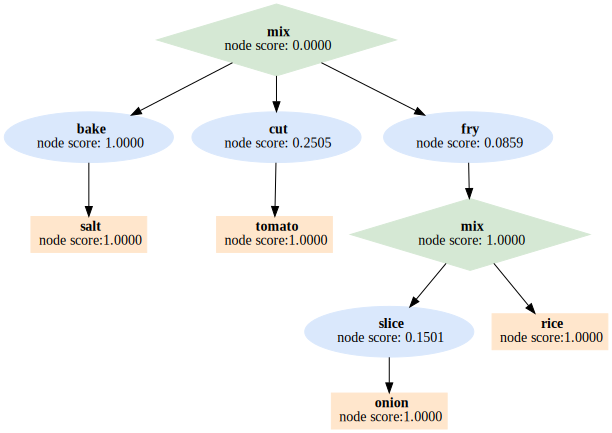

In [26]:
root_node.dot()

In [27]:
constant_ingredients = ["noodle", "onion", "tomato"]
main_ingredients = ['noodle']
min_additional = 3
max_additional = 6
top_ings =3

In [36]:
seen_items = set(constant_ingredients)

items = []
scores = []

assert set(main_ingredients).issubset(set(constant_ingredients))

# additional ingredients are choosen w.r.t all given ingredients
n_additional_ings = np.random.randint(min_additional, max_additional + 1)

# extra ings are ingredients choosen specially for the main ingredient
n_extra_ings = int((len(main_ingredients) / len(constant_ingredients)) * n_additional_ings)

if n_extra_ings > n_additional_ings:
    n_extra_ings = n_additional_ings

    
# choose extra ingredients
extra_candidates = []
extra_weights = []

for ing in main_ingredients:
    candidates, weights = normalized_score(ing, m_base_mix)
    extra_candidates.append(candidates[:10])
    extra_weights.append(weights[:10])

extra_ingredients = ea_tools.combined_wheel_of_fortune_selection(extra_candidates,
                                                                extra_weights,
                                                                n_extra_ings)

for ing in constant_ingredients:
    # find best matching ingredients
    best_items = []
    best_scores = []

    candidates, weights = m_base_mix.get_adjacent(ing)
    i = 0
    while i < len(candidates) and len(best_items) < top_ings:
        if candidates[i] not in seen_items:
            best_items.append(candidates[i])
            best_scores.append(weights[i])
        i += 1

    items.append(best_items)
    scores.append(best_scores)

#TODO: error handling if too few options are availabale!

additional_ingredients = ea_tools.combined_wheel_of_fortune_selection(items,
                                                             scores,
                                                             n_additional_ings - n_extra_ings)
list(constant_ingredients) + list(additional_ingredients) + list(extra_ingredients)

['noodle',
 'onion',
 'tomato',
 'salt',
 'cheese',
 'garlic clove',
 'olive oil',
 'mozzarella cheese']

In [32]:
normalized_score("noodle", m_base_mix)

(array(['ricotta cheese', 'spaghetti sauce', 'mozzarella cheese', 'cheese',
        'spinach', 'sausage', 'ground beef', 'tomato sauce', 'onion',
        'basil', 'broccoli', 'parsley', 'mushroom soup', 'mushroom',
        'sauce', 'egg', 'garlic clove', 'chicken', 'milk', 'water', 'salt',
        'zucchini', 'tomato', 'pepper', 'seasoning', 'green pepper',
        'shrimp', 'soy sauce', 'butter', 'red pepper', 'oregano',
        'clove garlic', 'olive oil', 'pork', 'carrot', 'green onion',
        'cream cheese', 'garlic', 'chicken broth', 'tablespoon butter',
        'red bell pepper', 'flour', 'cream', 'black pepper',
        'vegetable oil', 'chicken breast', 'sugar'], dtype='<U86'),
 array([1.72269296e-03, 1.36100201e-03, 4.55169243e-04, 1.77893267e-04,
        1.24020302e-04, 1.23572299e-04, 1.15856830e-04, 8.13045041e-05,
        7.44682982e-05, 6.11712938e-05, 5.25617916e-05, 4.61949373e-05,
        4.57840602e-05, 4.48640553e-05, 3.80872894e-05, 3.73615068e-05,
        3.41135

## Population

In [29]:
class Population(object):
    def __init__(self, start_ingredients, main_ingredients, n_population = 10, max_additional_ings=0):
        self.population = [Tree.from_ingredients(start_ingredients, main_ingredients, additional_ings=max_additional_ings) for i in range(n_population)]
        self._n = n_population
        self._mix_min = None
        self._mix_max = None
        self._act_min = None
        self._act_max = None
        self._mix_scores = None
        self._act_scores = None
        self._scores = None
    
    def mutate(self):
        for tree in self.population.copy():
            t_clone = tree.copy()
            t_clone.mutate()
            self.population.append(t_clone)
    
    def pairwise_competition(self):
        new_population = []
        indices = list(range(len(self.population)))
        random.shuffle(indices)
        
        for i in range(len(self.population) // 2):
            i_a = indices[2*i]
            i_b = indices[2*i+1]
            
            if self._scores[i_a] > self._scores[i_b]:
                new_population.append(self.population[i_a])
            else:
                new_population.append(self.population[i_b])
        
        self.population = new_population
    
    def hold_best(self, n=10):
        sorted_indices = np.argsort(-self._scores)
        
        self.population = np.array(self.population)[sorted_indices[:n]].tolist()
    
    def analyse_scores(self):
        for tree in self.population:
            min, max = tree.bounds_mix_scores()
            if min is not None and max is not None:
                if self._mix_min is None or min < self._mix_min:
                    self._mix_min = min
                if self._mix_max is None or max > self._mix_max:
                    self._mix_max = max
            
            min, max = tree.bounds_act_scores()
            if min is not None and max is not None:
                if self._act_min is None or min < self._act_min:
                    self._act_min = min
                if self._act_max is None or max > self._act_max:
                    self._act_max = max
    
    def single_score(self, mix_scores, act_scores, ing_scores):
        if mix_scores is None or act_scores is None or ing_scores is None:
            return 0
        score = (0.5 * np.average(mix_scores) + 0.5 * np.average(act_scores)) * np.average(ing_scores)
        # judging also how many actions we have. So far use a gaussian with mean at number of ingredients
        
        score *= gaussian(len(act_scores), len(mix_scores), 1)
        return score
        
        
    
    def collect_scores(self):
        for tree in tqdm(self.population, desc="evaluate population scores",  leave=False):
            tree.collect_scores()
        
        self.analyse_scores()
        
        if self._mix_min is not None and self._mix_max is not None:
            self._mix_scores = [t.normalized_mix_scores(self._mix_min, self._mix_max) for t in self.population]
        else:
            # if no normalization can be done, all values are the same or 0.
            # in this case just fill in zeros as score
            self._mix_scores = [np.zeros(shape=t._mix_scores.shape) for t in self.population]
        
        if self._act_min is not None and self._act_max is not None:
            self._act_scores = [t.normalized_act_scores(self._act_min, self._act_max) for t in self.population]
        else:
            self._act_scores = [np.zeros(shape=t._act_scores) for t in self.population]
        
        self._scores = []
        for i in range(len(self._mix_scores)):
            #print (self._mix_scores[i], self._act_scores[i])
            if self._act_scores is None or self._mix_scores is None or self._act_scores[i] is None:
                self._scores.append(0)
                continue
            
            s = self.single_score(self._mix_scores[i], self._act_scores[i], self.population[i].ing_scores())
            self._scores.append(s)
        self._scores = np.array(self._scores)
    
    def run(self, n=50):
        for i in tqdm(range(n), desc="run evolutionary cycles"):
            self.mutate()
            self.mutate()
            self.collect_scores()
            
            #self.pairwise_competition()
            #self.collect_scores()
            self.hold_best(self._n)
            
            
    
    def plot_population(self, collect_scores=True):
        if (collect_scores):
            self.collect_scores()
        #print(self._mix_scores)
        #print(self._act_scores)
        #print(self._scores)
        for i, t in enumerate(self.population):
            if (collect_scores):
                display(self._scores[i])
            display(t.root().dot())

## Run Evolutionary Algorithm

In [30]:
p = Population(["bacon", "tomato", "onion"],['noodle'], max_additional_ings=6)

In [24]:
#p_ingredient_unprepared(list(p.population[0].root().childs())[0]._name) < 0.2

In [26]:
#p.run(100)

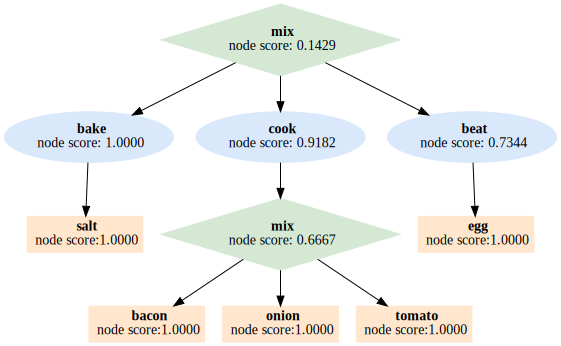

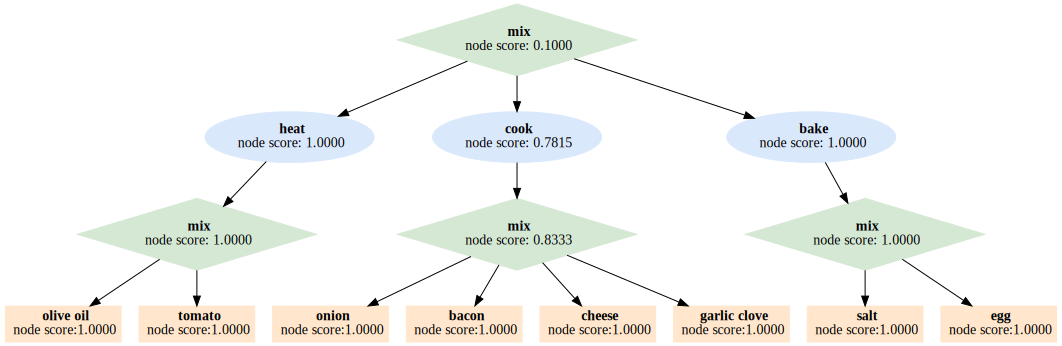

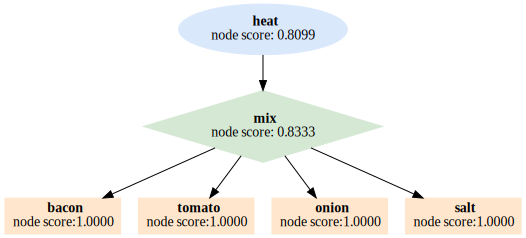

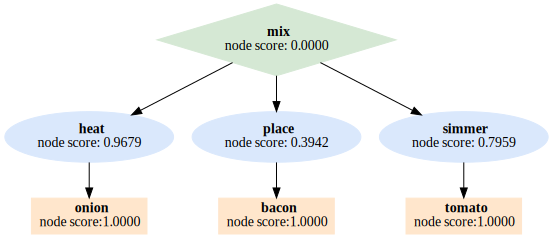

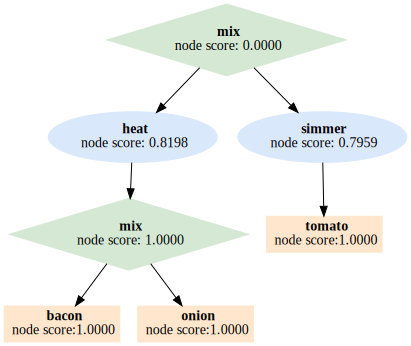

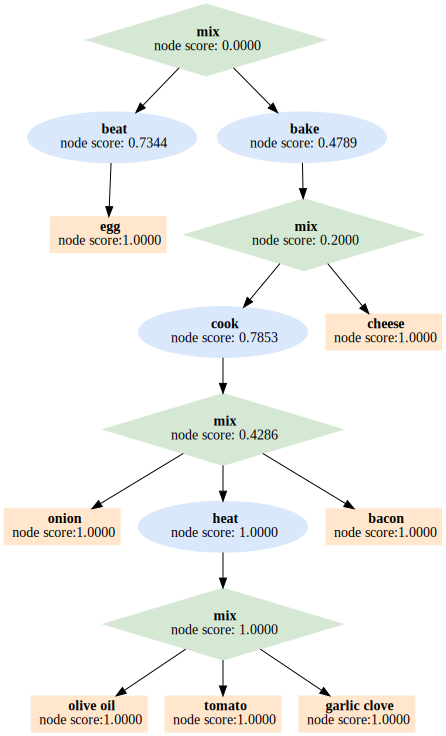

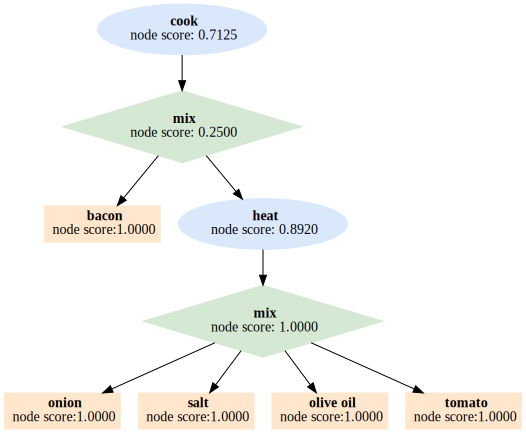

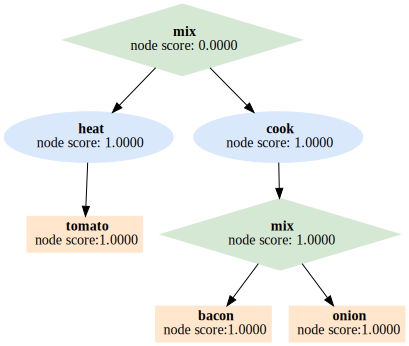

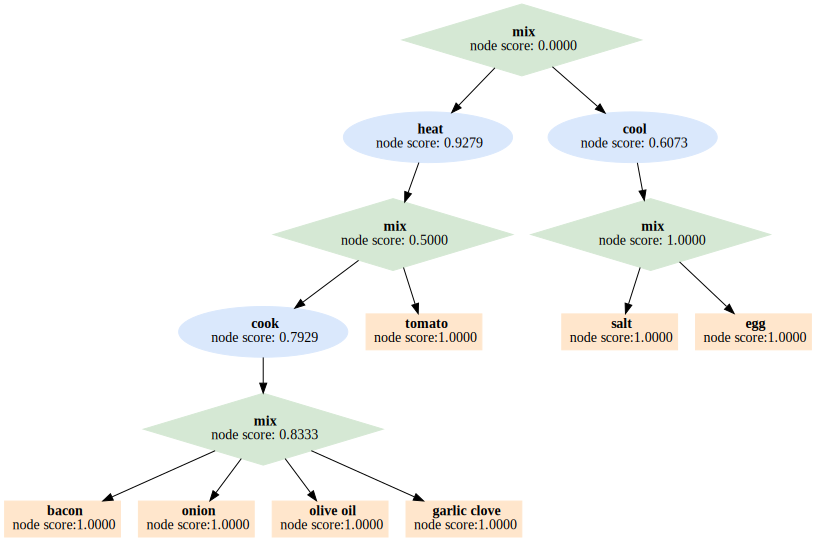

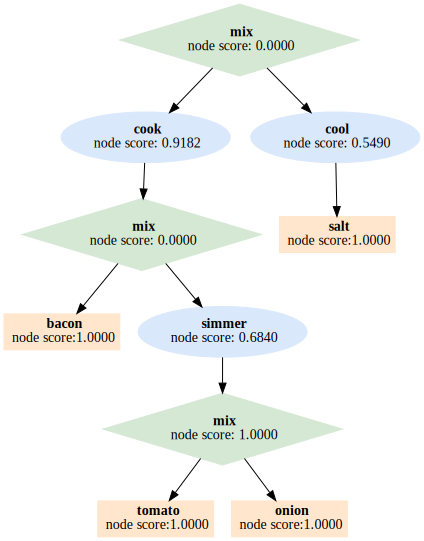

In [31]:
p.plot_population(collect_scores=False)